# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn. preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
import zipfile
from xgboost import XGBRegressor


This notebook is working with percentage of total data to predict compressive strength. Age is not included

In [2]:
#load data 
with zipfile.ZipFile('concrete+compressive+strength.zip') as z:
    with z.open('Concrete_Data.xls') as f:
        data = pd.read_excel(f)

In [3]:
#rename some of the column names
data.columns = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water', 'Superplasticizer', 'Coarse_Aggregate', 'Fine_Aggregate', 'Age (Days)', 'Compressive_Strength (MPa)']

In [4]:
#drop duplicates
data = data.drop_duplicates()

In [5]:
#make function to calculate total
def get_percentages(dataframe):
    my_kg = dataframe.iloc[:, :-1].sum(axis=1)
    my_copy = dataframe.copy()
    my_copy.iloc[:, :-2] = dataframe.iloc[:, :-2].div(my_kg, axis=0) * 100
    return my_copy

In [6]:
#get df of percentage of value per total
percentage_df = get_percentages(data)
percentage_df

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age (Days),Compressive_Strength (MPa)
0,22.054319,0.000000,0.000000,6.616296,0.102103,42.474985,27.608740,28,79.986111
1,21.920032,0.000000,0.000000,6.576010,0.101482,42.825249,27.440633,28,61.887366
2,13.305322,5.702281,0.000000,9.123649,0.000000,37.294918,23.769508,270,40.269535
3,12.818042,5.493446,0.000000,8.789514,0.000000,35.929067,22.898998,365,41.052780
4,7.391418,4.927612,0.000000,7.145781,0.000000,36.413711,30.723138,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,11.824093,4.962355,3.862936,7.683094,0.380732,37.221937,32.867043,28,44.284354
1026,13.987410,0.000000,5.018450,8.508791,0.451487,35.506837,35.311483,28,31.178794
1027,6.468615,6.072222,4.730583,8.393954,0.265714,38.872675,33.976565,28,23.696601
1028,6.801471,7.981361,0.000000,7.506840,0.483071,42.305062,33.725205,28,32.768036


In [33]:
#declare variables and split data

X_var = data.iloc[:, 0:8]
y_var = data['Compressive_Strength (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size=0.3, shuffle=True)

In [8]:
#function to eval models
def eval_model(actual_data, predict_data):
    r2 = r2_score(actual_data, predict_data)
    mae = mean_absolute_error(actual_data, predict_data)
    mse = mean_squared_error(actual_data, predict_data)
    explained_variance = explained_variance_score(actual_data, predict_data)
    print(f"R2: {r2}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"Explained Variance: {explained_variance}")

In [9]:
#winsorization function
def winsorization(dataframe, lower_limit, upper_limit, axis=None):
    clipped = dataframe.clip(dataframe.quantile(lower_limit), dataframe.quantile(upper_limit), axis=axis)
    return clipped 

Apply Winsorization to percentages df

In [37]:
#declare columns to winsorize
columns_to_winsorize = ['Water', 'Superplasticizer'] 
columns_to_transform = list(X_var.columns)

#declare transformers
winsorizer = FunctionTransformer(func=winsorization, kw_args={'lower_limit': 0, 'upper_limit': 0.99, 'axis': 1})
quartiles = QuantileTransformer(output_distribution='normal')

#declare transformer
transformer = ColumnTransformer(transformers=[
    ('winsorize', winsorizer, columns_to_winsorize),
    ('quartiles', quartiles, columns_to_transform)
], remainder='passthrough')

In [32]:
columns_to_transform

['Cement',
 'Blast_Furnace_Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse_Aggregate',
 'Fine_Aggregate',
 'Age (Days)',
 'Compressive_Strength (MPa)']

# PCA - for later incorporation

In [11]:
#initialize and fit
pca = PCA()

pca.fit_transform(X_train, y_train)

array([[  42.83369027,  -29.03651426,  249.64359358, ...,  -69.32515555,
         -11.05644196,   -5.48979852],
       [-156.9607403 ,  134.2158803 ,   25.55229624, ...,    2.76668003,
           1.93259712,    3.71143646],
       [  79.22736379,  -60.76965613,   -1.26557074, ...,   24.20916564,
           8.7625523 ,   -0.28666331],
       ...,
       [  48.8789218 ,  134.28191032,   38.26798793, ...,  -54.29588242,
           2.45396133,   -1.77457238],
       [-184.99983681,   89.97037686,   81.12313225, ...,    7.51923328,
           5.19229061,    0.77810168],
       [-173.76048321,   45.82519696,   51.87351363, ...,  -19.59029671,
          -5.40772868,    1.20828433]])

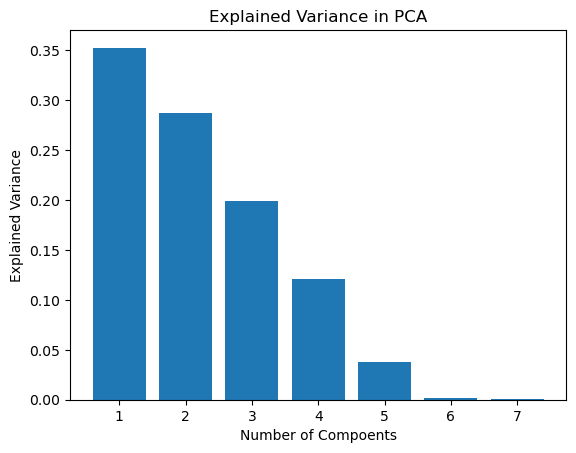

In [12]:
#get explained variance
variance = pca.explained_variance_ratio_


#plot scores
plt.bar(range(1, len(variance) + 1), variance)
plt.xlabel("Number of Compoents")
plt.ylabel("Explained Variance")
plt.title("Explained Variance in PCA")
plt.show()

# Ridge Regression Base

In [13]:
#initialize pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

In [14]:
#fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

In [15]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [16]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.4588408924051849
MAE: 9.950813229952114
MSE: 148.96340505747102
Explained Variance: 0.4588408924051849


In [17]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.34581078576062074
MAE: 9.895074962851819
MSE: 157.42538692786889
Explained Variance: 0.3546287736520195


## Ridge with Transformation

In [38]:
#initialize pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

In [39]:
#fit model
pipeline.fit(X_train, y_train)

/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (703). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function winsorization at 0x7ff8266e56c0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0,
                                                                               'upper_limit': 0.99}),
                                                  ['Water',
                                                   'Superplasticizer']),
                                                 ('quartiles',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['Cement',
                                                   'Blast_Furnace_Slag',
                                                   'Fly_Ash', 'Water',
                                                   'Superplasticizer',
                                                   'Coarse_Aggregate',
                                                   'Fine_Aggregate',
                                                   'Age (Days)'])])),
                ('scaler', StandardScaler()), ('regressor', Ridge())])

In [40]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [41]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.7415650506193593
MAE: 6.228825091548829
MSE: 67.92000834832373
Explained Variance: 0.7415650506193593


In [42]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.7227267655241877
MAE: 6.235093485379218
MSE: 74.4823225036105
Explained Variance: 0.7228271397513963


Transformation improved the model, but still over fitting. Let's try to add PCA with 3 and 4 components

## Ridge + Transformed + PCA

In [43]:
#initialize pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('regressor', Ridge())
])

In [44]:
#fit model
pipeline.fit(X_train, y_train)

/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (703). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function winsorization at 0x7ff8266e56c0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0,
                                                                               'upper_limit': 0.99}),
                                                  ['Water',
                                                   'Superplasticizer']),
                                                 ('quartiles',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['Cement',
                                                   'Blast_Furnace_Slag',
                                                   'Fly_Ash', 'Water',
                                                   'Superplasticizer',
                                                   'Coarse_Aggregate',
                                                   'Fine_Aggregate',
                                                   'Age (Days)'])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('regressor', Ridge())])

In [45]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [46]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.5583421897821317
MAE: 8.653606143942508
MSE: 116.07331836886259
Explained Variance: 0.5583421897821317


In [47]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.580505345251107
MAE: 8.814845488939387
MSE: 112.68644888359542
Explained Variance: 0.582987689496063


# Base model - Random Forest
Raw data compare standard scaler 

In [20]:
#pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

In [21]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [22]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [23]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.6828260460867349
MAE: 6.6368754451262655
MSE: 79.84950172543535
Explained Variance: 0.6828388678496158


In [24]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.39913229397416194
MAE: 10.548173606171193
MSE: 177.4385067809451
Explained Variance: 0.4020269802412223


Yikes...

In [25]:
#pipeline with 
#pipeline
pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor())
])

In [26]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('regressor', RandomForestRegressor())])

In [27]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [28]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.6832211142643063
MAE: 6.602212516253485
MSE: 79.75004211742707
Explained Variance: 0.6832211413906625


In [29]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.398851865181419
MAE: 10.546296154363553
MSE: 177.52131846435506
Explained Variance: 0.40215482195299557


Not much of a difference

# Base + winsorization

In [43]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

In [44]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('winsorize',
                                                  FunctionTransformer(func=<function winsorization at 0x7f22ee35b420>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0,
                                                                               'upper_limit': 0.99}),
                                                  ['Water',
                                                   'Superplasticizer'])])),
                ('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [45]:
#eval train model
eval_model(y_train, train_pred)

R2: 0.6832211142643063
MAE: 6.602212516253485
MSE: 79.75004211742707
Explained Variance: 0.6832211413906625


In [46]:
#eval test model
eval_model(y_test, test_pred)

R2: 0.398851865181419
MAE: 10.546296154363553
MSE: 177.52131846435506
Explained Variance: 0.40215482195299557
